In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [69]:
# Data processing

df = pd.read_csv('sample_data/drug.csv')

# Changing target column (Drug) to DrugY = 1 drugX = 0 drugC = 2
drug_mapping = {
    'drugX' : 0,
    'DrugY' : 1,
    'drugC' : 2,
    'drugA' : 3,
    'drugB' : 4
}
df['Drug'] = df['Drug'].map(drug_mapping)

# Changing the Sex column to M = 0 F = 1
sex_mapping = {
    'F' : 1,
    'M' : 0,
}
df['Sex'] = df['Sex'].map(sex_mapping)

# Changing the BP column to LOW = 0, NORMAL = 1, HIGH = 2
BP_mapping = {
    'LOW' : 0,
    'NORMAL' : 1,
    'HIGH' : 2,
}
df['BP'] = df['BP'].map(BP_mapping)


# Changing the Cholesterol column HIGH = 1, LOW = 0
Cholesterol_mapping = {
    'NORMAL' : 0,
    'HIGH' : 1,
}
df['Cholesterol'] = df['Cholesterol'].map(Cholesterol_mapping)

# Normalizing data between -1 and 1 for tanh
Xdf = df.iloc[:,:-1]
Ydf = df.iloc[:,-1]
min_values = Xdf.min()
max_values = Xdf.max()

# Normalize each value between -1 and 1
Xdf = (2 * (Xdf - min_values) / (max_values-min_values)) - 1

# Convert to numpy
X = Xdf.to_numpy(dtype=np.float32)
Y = Ydf.to_numpy(dtype=int)


In [70]:
# Creating a pytorch dataset
# Splitting the data into train and test
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

class DrugDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.x = torch.from_numpy(X_data).float()
        self.y = torch.from_numpy(y_data).long()
        self.n_samples = self.y.shape[0]

    def __getitem__(self, n):
        return self.x[n], self.y[n]

    def __len__(self):
        return self.n_samples

train_dataset = DrugDataset(X_train, y_train)
val_dataset = DrugDataset(X_val, y_val)

train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=32, shuffle=False)


In [71]:
# Pytorch Neural Network class
class NeuralNet(nn.Module):
    def __init__(self, features, l1_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(features, l1_size)
        self.batch_norm1 = nn.BatchNorm1d(l1_size)
        self.tanh = nn.Tanh()
        self.l2 = nn.Linear(l1_size, num_classes)

    def forward(self, in_put):
        l1_out = self.batch_norm1(self.tanh(self.l1(in_put)))
        l2_out = self.l2(l1_out)
        return l2_out

In [72]:
# Hyper Parameters

criterion = nn.CrossEntropyLoss()
model = NeuralNet(5, 6, 5)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

train_losses = []
val_losses = []

epochs = 1000
total_samples = len(train_dataset)
n_iterations = math.ceil(total_samples/32)

In [73]:
# Training

for epoch in range(epochs):
    epoch_train_loss = 0

    model.train()
    for i, (inputs, labels) in enumerate(train_loader):
        print(f'epoch {epoch+1}/{epochs}, step {i+1} / {n_iterations} ')

        outputs = model.forward(inputs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_train_loss += loss.item()

    avg_train_loss = epoch_train_loss / n_iterations
    print(f'loss = {avg_train_loss}')
    train_losses.append(avg_train_loss)

    # Evaluate on validation set
    model.eval()
    with torch.no_grad():
        avg_val_loss = 0
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            avg_val_loss += loss.item()

    print(f'Validation Loss = {avg_val_loss/len(val_loader)}')
    val_losses.append(avg_val_loss/len(val_loader))


Streaming output truncated to the last 5000 lines.
loss = 0.36763228178024293
Validation Loss = 0.3179337829351425
epoch 287/1000, step 1 / 5 
epoch 287/1000, step 2 / 5 
epoch 287/1000, step 3 / 5 
epoch 287/1000, step 4 / 5 
epoch 287/1000, step 5 / 5 
loss = 0.3396234571933746
Validation Loss = 0.3175550848245621
epoch 288/1000, step 1 / 5 
epoch 288/1000, step 2 / 5 
epoch 288/1000, step 3 / 5 
epoch 288/1000, step 4 / 5 
epoch 288/1000, step 5 / 5 
loss = 0.36333866119384767
Validation Loss = 0.31080426275730133
epoch 289/1000, step 1 / 5 
epoch 289/1000, step 2 / 5 
epoch 289/1000, step 3 / 5 
epoch 289/1000, step 4 / 5 
epoch 289/1000, step 5 / 5 
loss = 0.39731237292289734
Validation Loss = 0.31499841809272766
epoch 290/1000, step 1 / 5 
epoch 290/1000, step 2 / 5 
epoch 290/1000, step 3 / 5 
epoch 290/1000, step 4 / 5 
epoch 290/1000, step 5 / 5 
loss = 0.351317298412323
Validation Loss = 0.3170194625854492
epoch 291/1000, step 1 / 5 
epoch 291/1000, step 2 / 5 
epoch 291/1000

1000
1000


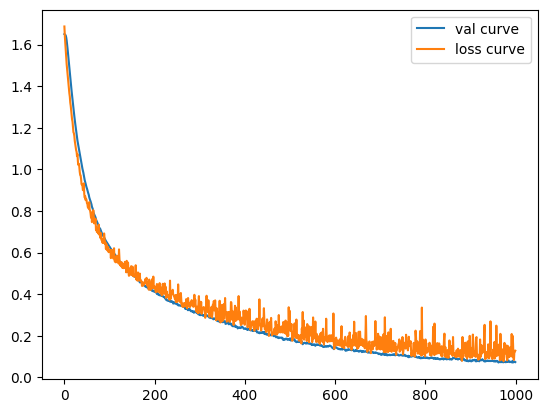

In [74]:
# Graph Plotting

print(len(val_losses))
print(len(train_losses))

plt.plot(list(range(len(train_losses))),val_losses, label='val curve')
plt.plot(list(range(len(train_losses))),train_losses, label='loss curve')
plt.legend()